## [Molecular Dynamics with DeePMD](https://github.com/deepmodeling/deepmd-kit) [<a href="https://tutorials.deepmodeling.com/en/latest/" style="color:orange">DeepModeling Tutorial!</a>]

#### Required Libraries : [numpy](https://pypi.org/project/numpy/), [pandas](https://pandas.pydata.org/), [deepmd](https://github.com/deepmodeling/deepmd-kit),[dpdata](https://github.com/deepmodeling/dpdata), [ase](https://pypi.org/project/ase/), [matplotlib](https://pypi.org/project/matplotlib/)

<p style="text-align:justify;">
    This is a <code style="background-color: Grey;"><b>DeePMD</b></code> tutorial, a Machine Learning Interatomic Potential (MLP) model for interatomic potential energy and force field to perform molecular dynamics (MD).
    <br><br>
    <code style="color: green;"><b>Example: **1,3-Butadiene** cyclization. </b></code>
    <br><br>
    In practice, the construction of MLPs typically involves three main steps:
    <ol>
        <li>Data generation</li>
        <li>Training</li>
        <li>Molecular Dynamics</li>
    </ol>
    <!---->
    <img src="fes.jpeg" alt="FES Image" style="width: 100%; max-width: 400px; height: auto; float: right; margin-left: 15px;">
    <!---->
    <br>
    For data generation, we will use the <a href="https://www.vasp.at/">VASP</a> package. 
    <br><br>
    Here, I will not go into the details for generating the initial configuration. However, there are several ways to do that. A straightforward approach involves performing a classical MD simulation to obtain random configurations. Subsequently, <i>ab-initio</i> calculations are performed to compute the potential energy and corresponding forces.
    <br><br>
    The output configurations are stored in the folder inside the <i>00.data</i> directory.
    <br><br>
</p>


<div class="alert alert-block alert-info">
    <span style="font-size: 1.2em; color: green;"> <b>Note:</b> Energies and forces for these configurations are obtained using PBE functional. </span>
</div>

In [80]:
import os
import glob
import numpy as np
import pandas as pd
import dpdata
import ase
from ase.io import read, write

In [85]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150  # Set DPI for all figures

In [3]:
prefix_path = os.getcwd()
print(prefix_path)

/Users/rverma7/Library/CloudStorage/OneDrive-NorthCarolinaStateUniversity/NCSU_Work/DeePMD/Butadiene/from_traj/Tutorial


## <span style="color:olive;">1. Data Generation</span>

In [4]:
os.chdir(
    os.path.join(prefix_path, '00.data')
)
!pwd
!ls

/Users/rverma7/Library/CloudStorage/OneDrive-NorthCarolinaStateUniversity/NCSU_Work/DeePMD/Butadiene/from_traj/Tutorial/00.data
POSCAR              conf.lmp            training_data
btd_trj-nqp-alg.npz outcar_files        validation_data


#### We will use the [dpdata](https://github.com/deepmodeling/dpdata) package to extract the data from output files

In [28]:
# save LAMMPS input ('conf.lmp') from initial POSCAR file
d_poscar = dpdata.System("POSCAR", fmt="vasp/poscar")
d_poscar.to("lammps/lmp", "conf.lmp", frame_idx=0)

In [4]:
vasp_multi_system = dpdata.MultiSystems.from_dir(
    dir_name="./outcar_files", file_name="OUTCAR.*", fmt="vasp/outcar"
)

In [5]:
vasp_multi_system.systems['C4H6'].data['energies']

array([-56.84108364, -56.84454623, -56.69026115, ..., -56.48688374,
       -56.35107127, -56.58241751])

In [6]:
print(vasp_multi_system.systems['C4H6'])

data = vasp_multi_system.systems['C4H6']

Data Summary
Labeled System
-------------------
Frame Numbers      : 4400
Atom Numbers       : 10
Including Virials  : Yes
Element List       :
-------------------
C  H
4  6


In [7]:
def vasp_dpmd_extract(dataset):
    
    # get total number of frames in dataset
    n_frames = dataset.get_nframes()
    print("# the data contains %d frames" % n_frames)
    # split training and validation data in 80% and 20%
    trr = int(n_frames*0.8)    # len -> training data
    val = n_frames - trr       # len -> validation data
    
    # random index for validation choice
    # rng = np.random.default_rng()
    # index_validation = rng.choice(n_frames, size=val, replace=False)
    index_validation = np.random.choice(n_frames, size=val, replace=False)
    
    # other indexes are training_data
    index_training = list(set(range(n_frames)) - set(index_validation))
    # extracting training and validation data
    data_training   = dataset.sub_system(index_training)
    data_validation = dataset.sub_system(index_validation)
    
    # all training data put into directory:"training_data"
    data_training.to_deepmd_npy("training_data")
    
    # all validation data put into directory:"validation_data"
    data_validation.to_deepmd_npy("validation_data")
    
    print("# the training data contains %d frames" % len(data_training))
    print("# the validation data contains %d frames" % len(data_validation))

In [8]:
vasp_dpmd_extract(dataset=data)

# the data contains 4400 frames
# the training data contains 3520 frames
# the validation data contains 880 frames


In [5]:
def plot_data(dir_name):
    
    en_tr = np.load(f'{dir_name}/training_data/set.000/energy.npy')
    en_vl = np.load(f'{dir_name}/validation_data/set.000/energy.npy')
    
    print(en_tr.size,en_vl.size)
    
    plt.scatter(range(len(en_vl)), en_vl, s=10, color='red', alpha=0.5, label=f'{dir_name}/validation_data')
    plt.scatter(range(len(en_tr)), en_tr, s=10, color='blue', alpha=0.5, label=f'{dir_name}/training_data')

    plt.xlim(0,None)
    
    plt.legend()
    plt.grid(ls='-.')
    plt.show()

3520 880


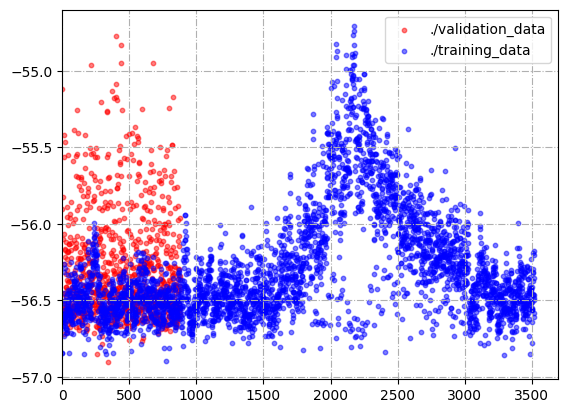

In [6]:
plot_data('.')

## <span style="color:olive;">2. Training (DeePMD)</span>

<div class="alert alert-block alert-success">
    <span style="font-size: 1.2em; color: green;"> #! Using the DFT energies and forces to train a model for potential energy surface (PES). </span>
</div>

In [7]:
os.chdir(
    os.path.join(prefix_path, '01.train/')
)
!pwd

/Users/rverma7/Library/CloudStorage/OneDrive-NorthCarolinaStateUniversity/NCSU_Work/DeePMD/Butadiene/from_traj/Tutorial/01.train


### Example of `input script` for the training: 
<br><br>
- `model defintion`
```bash
{
    "_comment": " model parameters",
    "model": {
	"type_map":	["C", "H"],
	"descriptor" :{
	    "type":		"se_e2_a",
	    "sel":		"auto",
	    "rcut_smth":	0.50,
	    "rcut":		6.00,
	    "neuron":		[20, 40, 80],
	    "resnet_dt":	false,
	    "axis_neuron":	16,
	    "seed":		13245,
	    "_comment":		" that's all"
	},
	"fitting_net" : {
	    "neuron":		[100, 100, 100],
	    "resnet_dt":	true,
	    "seed":		13245,
	    "_comment":		" that's all"
	},
	"_comment":	" that's all"
    },
```
<br>

- `optimization process and loss function`

```bash
  "learning_rate" :{
	"type":		"exp",
	"decay_steps":	5000,
	"start_lr":	0.001,
	"stop_lr":	3.51e-8,
	"_comment":	"that's all"
    },

    "loss" :{
	"type":		"ener",
	"start_pref_e":	0.02,
	"limit_pref_e":	1,
	"start_pref_f":	1000,
	"limit_pref_f":	1,
	"start_pref_v":	0,
	"limit_pref_v":	0,
	"_comment":	" that's all"
    },
```
<br>

- `training and validation data`
```bash
    "training" : {
	"training_data": {
	    "systems":		["../00.data/training_data"],
	    "batch_size":	"auto",
	    "_comment":		"that's all"
	},
	"validation_data":{
	    "systems":		["../00.data/validation_data"],
	    "batch_size":	"auto",
	    "numb_btch":	1,
	    "_comment":		"that's all"
	},
	"numb_steps":	1000000,
	"seed":		13245,
	"disp_file":	"lcurve.out",
	"disp_freq":	1000,
	"save_freq":	10000,
	"_comment":	"that's all"
    },

    "_comment":		"that's all"
}
```

In [13]:
! dp train input.json

Instructions for updating:
non-resource variables are not supported in the long term
DEEPMD INFO    Calculate neighbor statistics... (add --skip-neighbor-stat to skip this step)
DEEPMD INFO    training data with min nbor dist: 0.9888341620312275
DEEPMD INFO    training data with max nbor size: [4 6]
DEEPMD INFO     _____               _____   __  __  _____           _     _  _   
DEEPMD INFO    |  __ \             |  __ \ |  \/  ||  __ \         | |   (_)| |  
DEEPMD INFO    | |  | |  ___   ___ | |__) || \  / || |  | | ______ | | __ _ | |_ 
DEEPMD INFO    | |  | | / _ \ / _ \|  ___/ | |\/| || |  | ||______|| |/ /| || __|
DEEPMD INFO    | |__| ||  __/|  __/| |     | |  | || |__| |        |   < | || |_ 
DEEPMD INFO    |_____/  \___| \___||_|     |_|  |_||_____/         |_|\_\|_| \__|
DEEPMD INFO    Please read and cite:
DEEPMD INFO    Wang, Zhang, Han and E, Comput.Phys.Comm. 228, 178-184 (2018)
DEEPMD INFO    Zeng et al, J. Chem. Phys., 159, 054801 (2023)
DEEPMD INFO    See https://deep

#### monitor the training process in the `lcurve.out` file 

In [14]:
! head -n 4 lcurve.out
! tail -n 4 lcurve.out

#  step      rmse_val    rmse_trn    rmse_e_val  rmse_e_trn    rmse_f_val  rmse_f_trn         lr
# If there is no available reference data, rmse_*_{val,trn} will print nan
      0      2.90e+01    3.54e+01      8.36e-01    8.23e-01      9.16e-01    1.12e+00    1.0e-03
   1000      1.76e+01    1.23e+01      3.41e-02    2.34e-02      5.57e-01    3.89e-01    1.0e-03
 997000      3.04e-02    2.25e-02      1.99e-03    3.10e-04      2.92e-02    2.21e-02    3.7e-08
 998000      2.60e-02    1.87e-02      7.42e-04    3.25e-04      2.54e-02    1.83e-02    3.7e-08
 999000      1.77e-02    1.71e-02      1.29e-04    2.31e-04      1.74e-02    1.67e-02    3.7e-08
1000000      2.35e-02    2.01e-02      6.59e-04    1.92e-04      2.30e-02    1.98e-02    3.5e-08


<span style="color:black; font-size:1.2em;">We can track the progress of the training by plotting the number of steps against various metrics: total RMS error (validation and training), RMS error in energy, RMS error in forces, and learning rate.</span>

In [18]:
def plot_lcurve(lcurve):
    with open(lcurve) as f:
        headers = f.readline().split()[1:]
    lcurve = pd.DataFrame(np.loadtxt(lcurve), columns=headers)
    legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val", "rmse_f_trn"]
    for legend in legends:
        plt.loglog(lcurve["step"], lcurve[legend], label=legend)
    plt.legend()
    plt.xlabel("Training steps")
    plt.ylabel("Loss")
    plt.show()

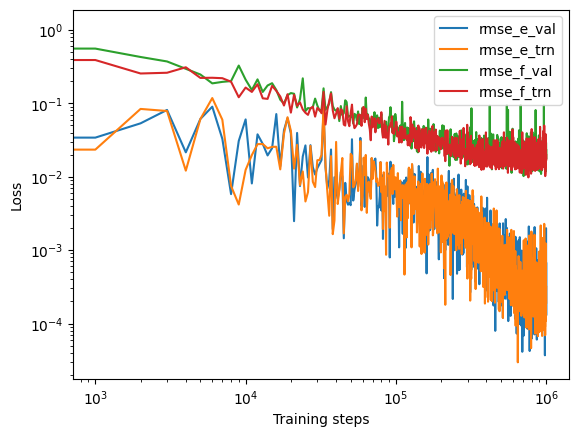

In [19]:
plot_lcurve(lcurve = "lcurve.out")

#### After completing the training, we can proceed to freeze the model using `dp freeze`. This will generate a deep potential file named `frozen_model.pb`. Now compress the model using `dp compress -t input.json -i frozen_model.pb -o frozen_model_1_compressed.pb`. This results in a compressed model (`frozen_model_1_compressed.pb`) 

In [ ]:
! dp compress

In [16]:
! dp test -m frozen_model_1_compressed.pb -s ../00.data/validation_data/

Instructions for updating:
non-resource variables are not supported in the long term
2024-05-22 18:55:16.971965: E tensorflow/core/framework/node_def_util.cc:630] NodeDef mentions attribute grad_y which is not in the op definition: Op<name=BatchMatMulV2; signature=x:T, y:T -> output:T; attr=T:type,allowed=[DT_BFLOAT16, DT_HALF, DT_FLOAT, DT_DOUBLE, DT_INT16, DT_INT32, DT_INT64, DT_COMPLEX64, DT_COMPLEX128]; attr=adj_x:bool,default=false; attr=adj_y:bool,default=false> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node load/filter_type_0/MatMul}}
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
DEEPMD WARNING You can use the environment variable DP_INFER_BATCH_SIZE tocontrol the inference batch size (nframes * natoms). The default value is 1024.
DEEPMD INFO    # ---------------output of dp test-

In [18]:
training_systems = dpdata.LabeledSystem("../00.data/training_data/", fmt="deepmd/npy", type_map = ["C", "H"])
predict = training_systems.predict(dp = "frozen_model_1_compressed.pb")

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-22 18:58:46.545002: E tensorflow/core/framework/node_def_util.cc:630] NodeDef mentions attribute grad_x which is not in the op definition: Op<name=BatchMatMulV2; signature=x:T, y:T -> output:T; attr=T:type,allowed=[DT_BFLOAT16, DT_HALF, DT_FLOAT, DT_DOUBLE, DT_INT16, DT_INT32, DT_INT64, DT_COMPLEX64, DT_COMPLEX128]; attr=adj_x:bool,default=false; attr=adj_y:bool,default=false> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node load/filter_type_0/MatMul}}
2024-05-22 18:58:46.650248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 18:58:46.667034: I tensorflow/core/common_runtime/process_util.cc:146] Creating 

#### Parity plot

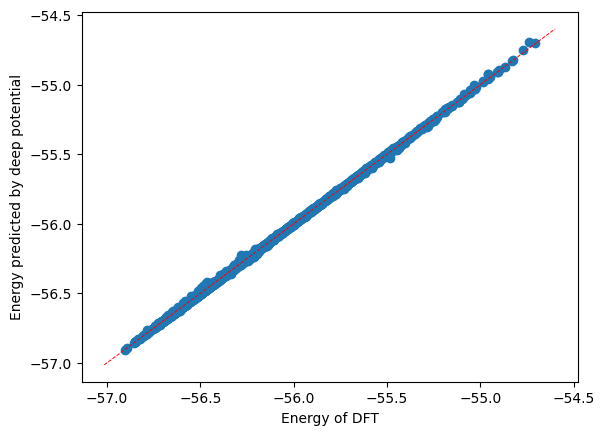

In [20]:
plt.scatter(training_systems["energies"], predict["energies"])
x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])

plt.plot(x_range, x_range, "r--", linewidth=0.7)
plt.xlabel("Energy of DFT")
plt.ylabel("Energy predicted by deep potential")
plt.plot();

## <span style="color:olive;">2. Run LAMMS molecular dynamics simulations</span>

In [22]:
os.chdir(
    os.path.join(prefix_path, '02.lmp')
)
!pwd

/Users/rverma7/Library/CloudStorage/OneDrive-NorthCarolinaStateUniversity/NCSU_Work/DeePMD/Butadiene/from_traj/Tutorial/02.lmp


#### LAMMPS script to run dynamics:

```bash
# https://www.youtube.com/watch?v=qsZQ2WPnScI&list=PLqT1fmMucKi712NWarqD4MLbDLH8hrmNj&index=3
# https://rb.gy/0vxw2q
# (1) Printing thermodynamic information
# (2) Printing coordinate information
# (3) Visualization of coordinates and some options in OVITO (https://www.ovito.org)
# (4) Any line beginning with a # is a comment line
# (5) Any line ending with & means the command continues in the next line
# ===========================================================================
# 1,3-Butadiene
units           metal
boundary        p p p
atom_style      atomic
# ===========================================================================
neighbor        2.0 bin
neigh_modify    delay 0 every 1 check yes
# ===========================================================================
read_data       conf.lmp
mass            1 12.0
mass            2 2
# ===========================================================================
variable        sysvol          equal vol
variable        sysmass         equal mass(all)/6.0221367e+23
variable        sysdensity      equal v_sysmass/v_sysvol/1.0e-24
variable	out_freq 	equal 100
# ===========================================================================
pair_style      deepmd frozen_model_1_compressed.pb frozen_model_2_compressed.pb frozen_model_3_compressed.pb frozen_model_3_compressed.pb out_file md.out out_freq 10 atomic relative 1.0
pair_coeff	* *
# ===========================================================================
#
velocity        all create 300.0 2345678 rot no dist gaussian
fix             1 all nvt temp 300.0 300.0 0.05
# ===========================================================================
timestep        0.0005
thermo_style    custom step pe ke etotal v_sysdensity temp press vol
thermo          10
# ===========================================================================
dump            10 all custom 100 btd.dump id type x y z
dump		101 all xyz 100 btd.xyz
dump_modify	101 element C H
# ===========================================================================
fix		extra all print 20 "$(step), $(ke), $(pe), $(etotal), $(temp), $(press), $(vol)" file logfile screen no
# ===========================================================================
restart	        100000 dump.restart

run             1000000
# ===========================================================================
```

#### input code block for DeePMD model:
```bash
pair_style  deepmd frozen_model_1_compressed.pb frozen_model_2_compressed.pb frozen_model_3_compressed.pb frozen_model_3_compressed.pb
pair_coeff	* *
```

<div class="alert alert-block alert-info">
    
<span style="color:black; font-size:1.1em;"><b>Note:</b> `frozen_model_#_compressed.pb` are four models trained on the same data and with different initial random seeds.</span>

</div> 

> ### conf.lmp
```bash

10 atoms
2 atom types
   0.0000000000   15.0000000000 xlo xhi
   0.0000000000   15.0000000000 ylo yhi
   0.0000000000   15.0000000000 zlo zhi

Atoms # atomic

     1      1    8.0910000000    7.6280000000    5.7850000000
     2      1    7.2030000000    7.5070000000    6.8330000000
     3      1    7.8050000000    7.4730000000    8.1490000000
     4      1    6.9260000000    7.4360000000    9.2110000000
     5      2    7.7120000000    7.6050000000    4.7210000000
     6      2    9.1340000000    7.6360000000    6.0390000000
     7      2    6.0970000000    7.4940000000    6.6630000000
     8      2    8.9140000000    7.4840000000    8.3510000000
     9      2    5.8210000000    7.3900000000    9.0180000000
    10      2    7.2960000000    7.3470000000   10.2290000000
```

In [32]:
! lmp_mpi -in input.lammps

LAMMPS (2 Aug 2023)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Loaded 1 plugins from /Users/rverma7/anaconda3/envs/deepmd/lib/deepmd_lmp
Reading data file ...
  orthogonal box = (0 0 0) to (15 15 15)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  10 atoms
  read_data CPU = 0.002 seconds
DeePMD-kit WARNING: Environmental variable TF_INTRA_OP_PARALLELISM_THREADS is not set. Tune TF_INTRA_OP_PARALLELISM_THREADS for the best performance. See https://deepmd.rtfd.io/parallelism/ for more information.
DeePMD-kit WARNING: Environmental variable TF_INTER_OP_PARALLELISM_THREADS is not set. Tune TF_INTER_OP_PARALLELISM_THREADS for the best performance. See https://deepmd.rtfd.io/parallelism/ for more information.
DeePMD-kit WARNING: Environmental variable OMP_NUM_THREADS is not set. Tune OMP_NUM_THREADS for the best performance. See https://deepmd.rtfd.io/parallelism/ for more information.
Summary of lammps dee

In [29]:
def plot_lammps(x, y, xlabel, ylabel, label):
    
    plt.figure(figsize=(8, 5))

    mean = np.mean(y)
    plt.plot(x, y, label=f'{label}', color='blue', lw=1, alpha=0.7)
    plt.axhline(y=mean, color='red', linestyle='--', label=f'Mean {label} = {mean:.2f}')
#
    # Add labels and legend
    plt.xlabel(f'{xlabel}')
    plt.ylabel(f'{ylabel}')

    plt.xlim(min(x), max(x))
    
#    plt.title(f'{label}')
    plt.grid(ls='-.')
    plt.legend()
    plt.tight_layout()
    plt.show()
#    plt.plot(log.get("Step"), log.get("Temp"))

<span style="color:black; font-size:1.5em;">[Lammps log file parser](https://github.com/henriasv/lammps-logfile):</span> `!pip install lammps-logfile`

In [26]:
import lammps_logfile as lmp_log

log = lmp_log.File('log.lammps')

print("Log keywords: ", log.get_keywords())

Log keywords:  ['KinEng', 'PotEng', 'Press', 'Step', 'Temp', 'TotEng', 'Volume', 'v_sysdensity']


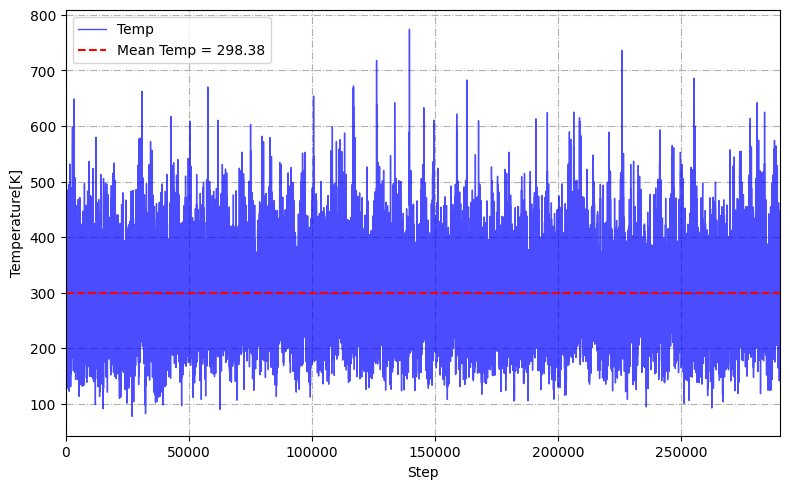

In [16]:
# Plot Temperature over the course of simulation
step = log.get("Step")
temp = log.get("Temp")

plot_lammps(x=step, y=temp, xlabel='Step', ylabel='Temperature[K]', label='Temp')

## <span style="color:olive;">3. Enhance sampling MD simulations using [PLUMED](https://www.plumed.org//)</span>

<span style="font-size: 18px;">We will perform <a href="https://www.plumed.org/doc-v2.8/user-doc/html/belfast-4.html">Umbrella sampling</a> simulation.</span>

In [38]:
os.chdir(
    os.path.join(prefix_path, '03.plumed')
)
!pwd

/Users/rverma7/Library/CloudStorage/OneDrive-NorthCarolinaStateUniversity/NCSU_Work/DeePMD/Butadiene/from_traj/Tutorial/03.plumed


>### plumed.dat

```bash
# PLUMED FILE
# -------------------------------------
# 		UNITS
# -------------------------------------
UNITS LENGTH=A ENERGY=kcal/mol
#
d1: DISTANCE ATOMS=1,4
d2: DISTANCE ATOMS=2,1
d3: DISTANCE ATOMS=3,2
d4: DISTANCE ATOMS=4,3
#
# Activate Umbrella Sampling in distance (butadiene)
# with kapps equal to 0.4au/Bohr (224.1 kcal/mol/Ang^2), distance equal Angstrom
#

rest: RESTRAINT ARG=d1 KAPPA=896.4 AT=1.3

FLUSH STRIDE=100

PRINT ARG=d1,d2,d3,d4,rest.bias STRIDE=100 FILE=COLVAR
```

<span style="font-size: 16px;">
We need to add the following line in the LAMMPS input file.
</span>

```css
fix    2 all plumed plumedfile plumed.dat outfile PLUMED.log
```

In [53]:
from scipy.interpolate import interp1d

In [43]:
os.chdir(
    os.path.join(prefix_path, '03.plumed', 'analysis')
)
!pwd

/Users/rverma7/Library/CloudStorage/OneDrive-NorthCarolinaStateUniversity/NCSU_Work/DeePMD/Butadiene/from_traj/Tutorial/03.plumed/analysis


we will be using [Reweighting-Package](https://github.com/rahulumrao/Reweighing-TASS-1.2) to reconstruct the free energy profile from PLUMED run

In [72]:
# Load the data
dft_fes_data = np.loadtxt('aimd_fes.dat', comments='!', skiprows=5, usecols=(0, 1))
dpmd_fes_data = np.loadtxt('interp_free_energy.dat', usecols=(0, 1))

#
print(f"DFT: \n {dft_fes_data[1:5]}, \n DeePMD: \n {dpmd_fes_data[1:5]}")

DFT: 
 [[ 0.7148395  48.8225759 ]
 [ 0.78459    48.75265659]
 [ 0.8543405  48.557655  ]
 [ 0.924091   48.07544632]], 
 DeePMD: 
 [[  1.41857143  -9.44430566]
 [  1.42785714  -9.92960753]
 [  1.43714286 -10.38017597]
 [  1.44642857 -10.79645904]]


In [73]:
# Separate positions and PMFs
dft_fes_pos, dft_fes_pmf = dft_fes_data[:, 0], dft_fes_data[:, 1]
dpmd_fes_pos, dpmd_fes_pmf = dpmd_fes_data[:, 0], dpmd_fes_data[:, 1]

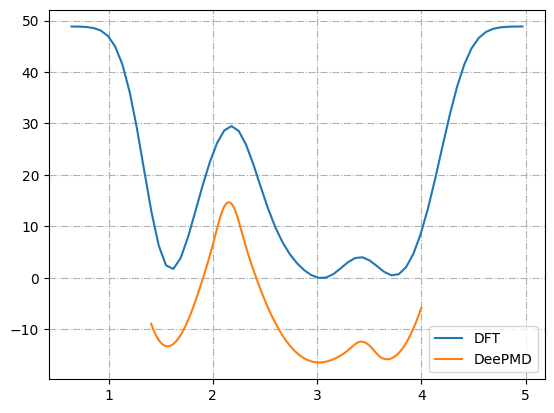

In [75]:
plt.plot(dft_fes_pos, dft_fes_pmf, label='DFT')
plt.plot(dpmd_fes_pos, dpmd_fes_pmf, label='DeePMD')

plt.legend()
plt.grid(ls='-.')
plt.show()

plt.show()

<div class="alert alert-block alert-success">
    <b>Info:</b> <span style="font-size: 1.2em; color: green;">Both plots are shifted along the Y-axis. Let's align these with respect to a certain value of X.<br>
    Also, since the <code style="background-color: grey;">DeePMD</code> has no data after a certain X-range, we will create a mask to filter out data outside this range: <code style="background-color: grey;">[xmin: 1.4, xmax: 4.0]</code></span>
</div>

In [48]:
def align_fes(dft_pos, dft_pmf, ml_pos, ml_pmf, pos_x=3.0):

    # Min and Max position at which PMF is considerd
    min_pos, max_pos = 1.4, 4.0
    # min_pos = min_x
    # max_pos = max_x

    # create a mask array to filter the positions outside of range (type[boolean: True or False])
    dft_mask = (dft_pos >= min_pos) & (dft_pos <= max_pos)
    ml_mask = (ml_pos >= min_pos) & (ml_pos <= max_pos)

    # Filter the positions outside of the range
    dft_fes_pos = dft_pos[dft_mask]
    dft_fes_pmf = dft_pmf[dft_mask]
    ml_fes_pos = ml_pos[ml_mask]
    ml_fes_pmf = ml_pmf[ml_mask]
    
    # Find the PMF values at position 3.0 for both datasets
    pos_x = pos_x
    dft_pmf_at_position = np.interp(pos_x, dft_fes_pos, dft_fes_pmf)
    ml_pmf_at_position = np.interp(pos_x, ml_fes_pos, ml_fes_pmf)
    
    # Calculate the difference at the specific position
    alignment_shift = dft_pmf_at_position - ml_pmf_at_position
    
    # Align dpmd_fes_pmf with dft_fes_pmf at position 3.0
    ml_fes_pmf += alignment_shift

    return dft_fes_pos, dft_fes_pmf, ml_fes_pos, ml_fes_pmf

In [49]:
dft_pos, dft_pmf, dpmd_pos, dpmd_pmf = align_fes(dft_fes_pos, dft_fes_pmf, dpmd_fes_pos, dpmd_fes_pmf)

In [96]:
def plt_fes(dft_pos, dft_pmf, ml_pos, ml_pmf, c1='red', c2='blue', model_1='DFT', ml_model='DeePMD'):
    
    plt.plot(dft_pos, dft_pmf, lw=1, c=f'{c1}', label=f'{model_1}', marker='o', ms=5, alpha=0.7)
    plt.plot(ml_pos, ml_pmf, lw=2, c=f'{c2}', label=f'{ml_model}')

    plt.xlabel(r'distance ($\rm{\AA}$)')
    plt.ylabel('Free Energy (kcal/mol')
    
    plt.legend()
    plt.grid(ls='-.')
    plt.show()
    
    plt.show()

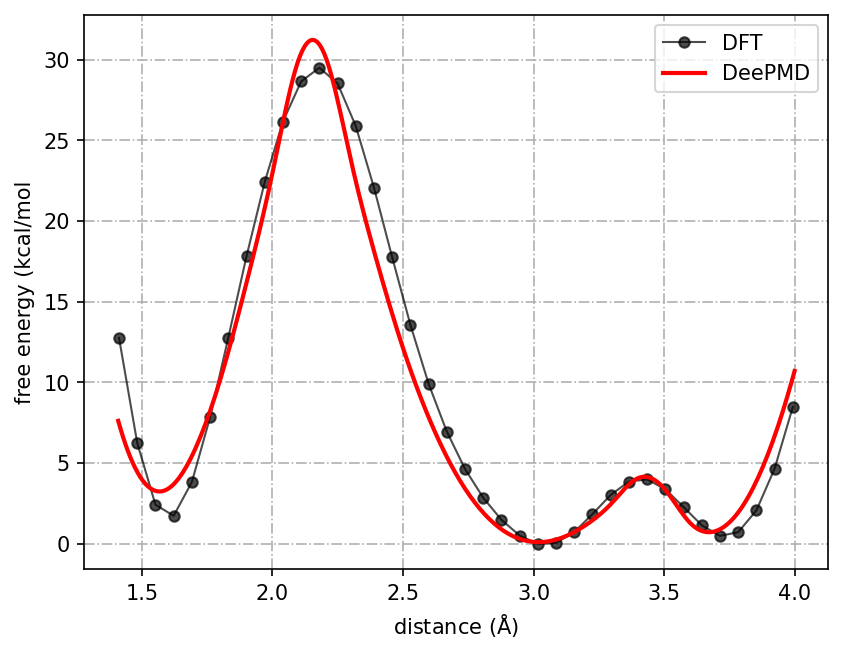

In [94]:
plt_fes(dft_pos, dft_pmf, dpmd_pos, dpmd_pmf, c1='black', c2='red', model_1='DFT', ml_model='DeePMD')

#### error between the free energies obtained from DFT and DeePMD simulation.

[Root Mean Square Deviation (RMSD) metrics:](https://pubs.acs.org/doi/suppl/10.1021/acs.jctc.5b00846/suppl_file/ct5b00846_si_001.pdf)

<center>

$$  RMSD(F, G) = \sqrt{\frac{1}{N} \sum_{i=1}^{N} [(F(S_i) - {\left \langle F(S) \right \rangle}) - (G(S_i) - {\left \langle G(S) \right \rangle})]^2} $$

</center>
<br>

#### where, 𝑆 is a collective variable, $\left \langle F(S))  \right \rangle$ and $\left \langle G(S))  \right \rangle$ are the DFT and DeePMD free energies averaged over N.

In [87]:
# Min and Max position at which PMF is considerd
min_pos, max_pos = 1.4, 4.0
# dpmd_fes_pmf_interp = np.interp(X_pos, dpmd_fes_pos, dpmd_fes_pmf)

# Scipy interpolation
X_pos = np.linspace(min_pos, max_pos, num=500)  # num --> number of interpolation points
dft_fes_pmf_interp = interp1d(dft_pos, dft_pmf, kind='linear', fill_value='extrapolate')(X_pos)
dpmd_fes_pmf_interp = interp1d(dpmd_pos, dpmd_pmf, kind='linear', fill_value='extrapolate')(X_pos)

# Calculate Root Mean Square Deviation (RMSD) with respect to the minimum PMF at postion 3.0
rmsd = np.sqrt(np.mean((dft_fes_pmf_interp - dpmd_fes_pmf_interp) ** 2))
print(f"Error between free energies: {rmsd:6f} kcal/mol")

# Save interpolated FES and positions to a file using numpy.vstack -> Stack arrays
output_data = np.vstack((X_pos, dft_fes_pmf_interp, dpmd_fes_pmf_interp)).T
np.savetxt('interpolated_fes.dat', output_data, header='#Position, DFT_FES_PMF, DPMD_FES_PMF', comments='')

# for i in range(len(common_positions)):
#     print(common_positions[i], dft_fes_pmf_interpolated[i], dpmd_fes_pmf_interpolated[i])

print("Interpolated FES and positions saved to 'interpolated_fes.dat'.")

Error between free energies: 1.701638 kcal/mol
Interpolated FES and positions saved to 'interpolated_fes.dat'.


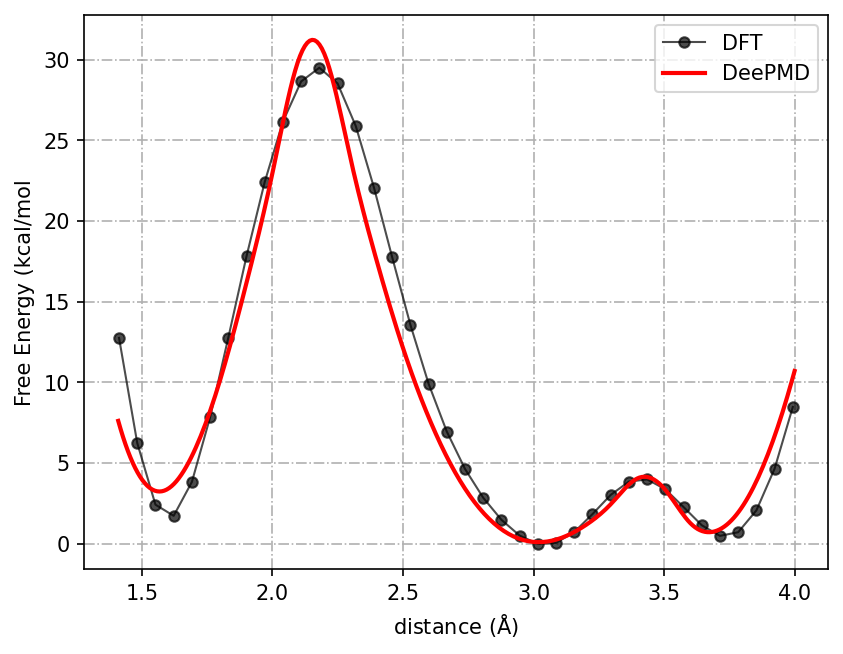

In [97]:
plt_fes(dft_pos, dft_pmf, dpmd_pos, dpmd_pmf, c1='black', c2='red', model_1='DFT', ml_model='DeePMD')